In [3]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']="1"

from fastprogress import master_bar, progress_bar
from fastai.vision import *
from fastai.distributed import *
from fastai.metrics import accuracy
import pandas as pd
import numpy as np
import random
import torch
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.nn as nn
#import pretrainedmodels
import math
import sys
import pickle
from arch import GeM, L2Norm
%config InlineBackend.figure_format ='retina'

SEED = 42
np.random.seed(SEED), random.seed(SEED), torch.random.manual_seed(SEED), torch.cuda.manual_seed_all(SEED)

(None, None, <torch._C.Generator at 0x7f9f8ffe0190>, None)

In [4]:
import pandas as pd
from pathlib import Path
path = Path('/content/drive/MyDrive/Train')
train_df = pd.read_csv(path / 'train.csv', usecols=[0,2], converters={'id':lambda x:x[0]+'/'+x[1]+'/'+x[2]+'/'+x})
train_df.head()
min_images, n_landmarks = 200, 1000
train_df = train_df.groupby('landmark_id').filter(lambda x: len(x) >= min_images)

In [5]:
import numpy as np
train_df = train_df[train_df['landmark_id'].isin(
    np.random.choice(train_df['landmark_id'].unique(), n_landmarks, replace=False))]

In [6]:
train_df.head()

,id,landmark_id
1,2/0/2/202cd79556f30760,104169
9,8/d/f/8df019949b8db328,81049
11,c/c/f/ccf070a2da242d56,138982
23,0/5/3/053d1409647dfba2,74821
25,3/c/d/3cdc355c6232712f,12877


from matplotlib import pyplot as plt
_df_0['landmark_id'].plot(kind='hist', bins=20, title='landmark_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['landmark_id'].plot(kind='line', figsize=(8, 4), title='landmark_id')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='landmark_id', y='id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [7]:
train_df['landmark_id'].nunique()

1000

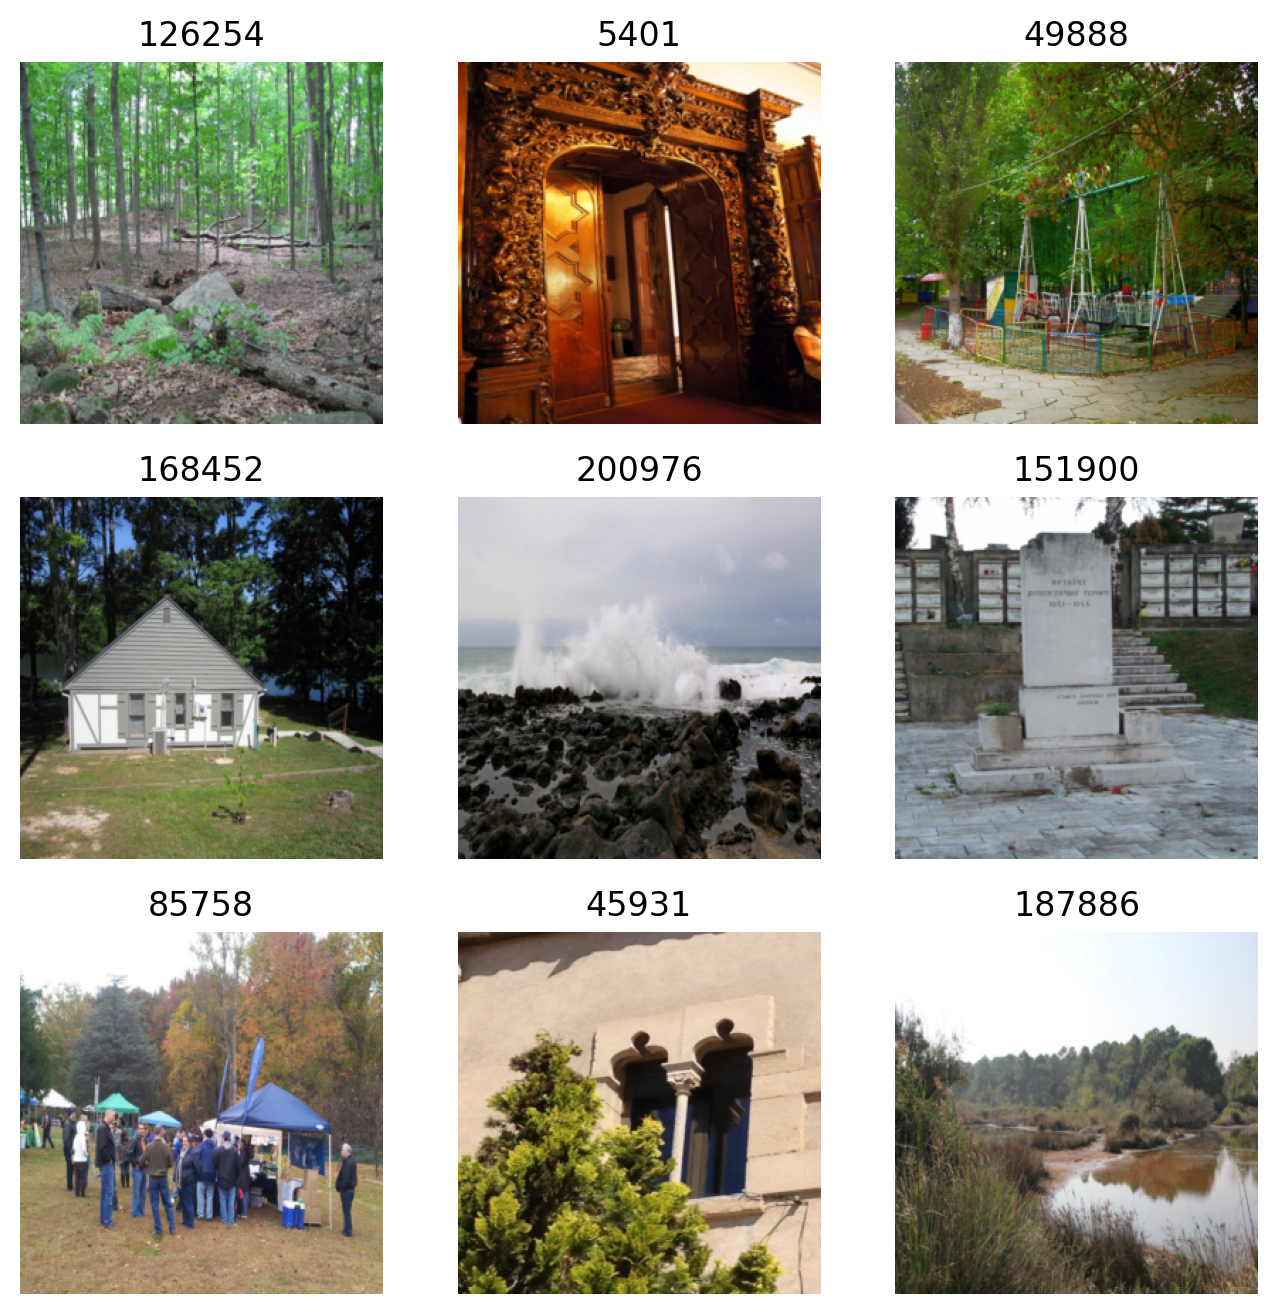

In [8]:
from fastai.vision.all import *
from pathlib import Path
import pandas as pd

# Đường dẫn đến thư mục chứa dữ liệu và tệp CSV
path = Path('/content/drive/MyDrive/Train')
csv_path = path / 'train.csv'

# Đọc tệp CSV và chuẩn bị dữ liệu
train_df = pd.read_csv(csv_path, usecols=[0, 2], converters={'id': lambda x: f"{x[0]}/{x[1]}/{x[2]}/{x}.jpg"})
train_df['filepath'] = train_df['id'].apply(lambda x: path / x)

# Loại bỏ các hàng có tệp ảnh bị thiếu
train_df = train_df[train_df['filepath'].apply(lambda x: x.exists())]

# Cấu hình các tham số
SZ = 256
BS = 48
NUM_WORKERS = 16
SEED = 42

# Khởi tạo DataBlock
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('filepath'),           # Sử dụng đường dẫn đầy đủ đến ảnh
    get_y=ColReader('landmark_id'),
    splitter=RandomSplitter(0.2, seed=SEED),
    item_tfms=Resize(SZ, method=ResizeMethod.Squish),
    batch_tfms=Normalize.from_stats(*imagenet_stats)
)

# Tạo DataLoaders từ DataBlock
dls = data_block.dataloaders(train_df, bs=BS, num_workers=NUM_WORKERS)

# Hiển thị một batch ảnh
dls.show_batch(max_n=9, figsize=(8, 8))



In [9]:
NUM_CLASSES = len(dls.vocab)
print(NUM_CLASSES)

20660


In [10]:
arch = models.resnet152
model_name = f'{arch.__name__}_i{min_images}_l{n_landmarks}-{SZ}'

In [11]:
archcut = nn.Sequential(
    *list(arch(weights=True).children())[:-2], nn.AdaptiveAvgPool2d(1),Flatten(), nn.Linear(2048, NUM_CLASSES))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 98.3MB/s]


In [12]:
import gc
import torch
from fastai.vision.all import ImageDataLoaders, Learner, accuracy, Resize
from torchvision.models import resnet152  # Import resnet152 từ torchvision.models

# Khởi tạo DataLoaders từ thư mục chứa dữ liệu
data = ImageDataLoaders.from_folder(
    '/content/drive/MyDrive/Train',  # Thay thế với đường dẫn chính xác đến thư mục của bạn
    valid_pct=0.2,                                        # Tỷ lệ chia dữ liệu thành tập kiểm tra
    item_tfms=Resize(224)                                 # Thay đổi kích thước ảnh
)

# Định nghĩa kiến trúc mô hình
archcut = resnet152()

gc.collect()
torch.cuda.empty_cache()

learn = Learner(data, archcut, metrics=[accuracy])



In [13]:
learn.model
#previous_model_name = 'resnet50_i200_l1000-256'

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
learn.summary()

ResNet (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 56 x 56  
Conv2d                                    16384      True      
BatchNorm2d                            

In [15]:
try:
    learn = learn.load(previous_model_name)
    print(f"Loaded {previous_model_name}")
except:
    pass

In [16]:
from fastai.vision.all import *
from fastai.callback.mixup import MixUp

# Khởi tạo ImageDataLoaders (đảm bảo cung cấp đúng đường dẫn)
data = ImageDataLoaders.from_folder('/content/drive/MyDrive/Train', valid_pct=0.2, bs=32)

# Khởi tạo Learner với MixUp callback
learn = vision_learner(data, resnet152, metrics=[accuracy], cbs=[MixUp()])

# In ra danh sách các callback functions trong Learner
print(learn.cbs)



Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:02<00:00, 97.5MB/s]


[TrainEvalCallback, Recorder, CastToTensor, ProgressCallback, MixUp]


In [ ]:
from fastai.vision.all import *
from fastai.callback.mixup import MixUp

# Khởi tạo ImageDataLoaders với Resize transform để đảm bảo tất cả ảnh có kích thước 256x256
data = ImageDataLoaders.from_folder(
    '/content/drive/MyDrive/Train',  # Thay thế đường dẫn phù hợp
    valid_pct=0.2,
    bs=16,  # Giảm batch size nếu bạn gặp lỗi
    num_workers=0,  # Đặt số lượng worker về 0
    item_tfms=Resize(256)  # Resize tất cả ảnh về kích thước 256x256
)

# Khởi tạo Learner với MixUp callback (có thể thử loại bỏ cbs nếu gặp lỗi)
learn = vision_learner(data, resnet152, metrics=[accuracy], cbs=[MixUp()])

# Tiến hành tìm learning rate (thử giảm start_lr và end_lr)
learn.lr_find(start_lr=1e-6, end_lr=1e-1)

# Tiến hành huấn luyện mô hình
learn.fit_one_cycle(15, 1e-3)


In [ ]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [ ]:
model_name = f'{arch.__name__}_i{min_images}_l{n_landmarks}-{SZ}'
learn.save(model_name)
previous_model_name = model_name


In [ ]:
previous_model_name

'resnet152_i200_l1000-256'